# Tilt and Compliance Corrections for OBS Data
This notebook contains the functions used to conduct tilt and compliance corrections for OBS records. Examples using data directly downloaded from IRIS are also provided at the end of this notebook.

In [27]:
#import needed packages.
from collections import OrderedDict
from utilities import sta_info_from_inv,plot_trace,segment_interpolate
from TCcorrection_funcs import docorrection,gettransfer, maxcompfreq
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from IPython.display import clear_output


['G03A', '7D', -126.162498, 40.059101, -4113.0, '00']
pressure channel BDH
vertical channel BHZ
resampling from 40 to 20
removing response for 7D.G03A..BHZ | 2012-01-21T00:00:00.000000Z - 2012-01-21T23:59:59.950000Z | 20.0 Hz, 1728000 samples using inv
getting transfer function ...


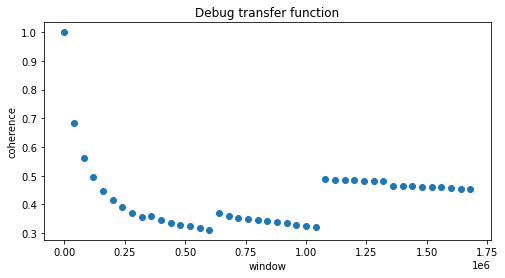

doing correction ...


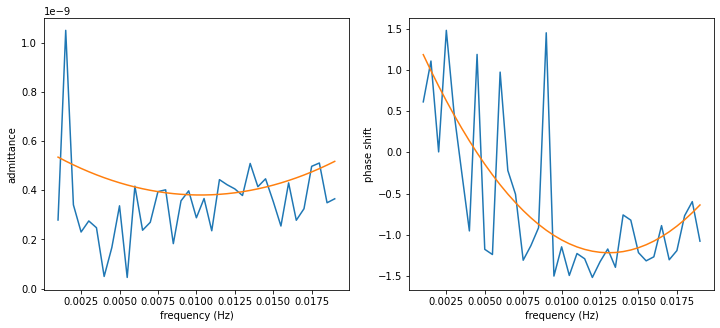

plotting ...
station 7D.G03A, filtered at [ 0.001,  0.019]
station 7D.G03A, filtered at [ 0.001,  0.019]
station 7D.G03A, filtered at [ 0.001,  0.019]
station 7D.G03A, filtered at [ 0.001,  0.019]


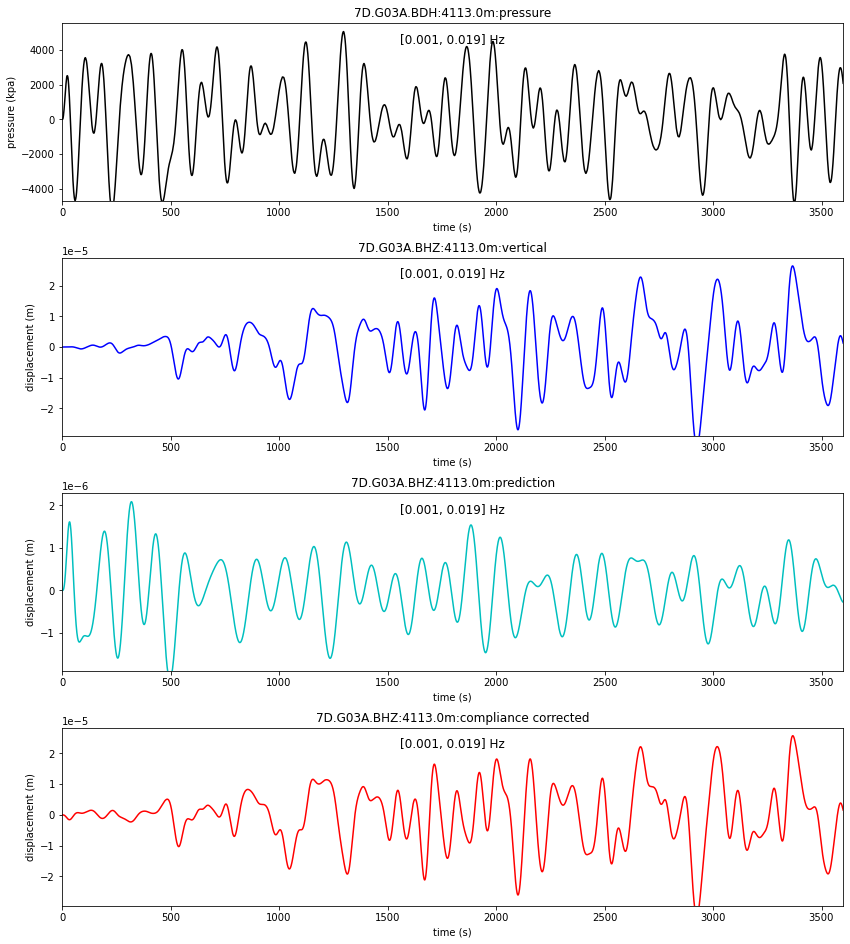

station 7D.G03A, filtered at [ 0.001,  0.019]
station 7D.G03A, filtered at [ 0.001,  0.019]
station 7D.G03A, filtered at [ 0.001,  0.019]


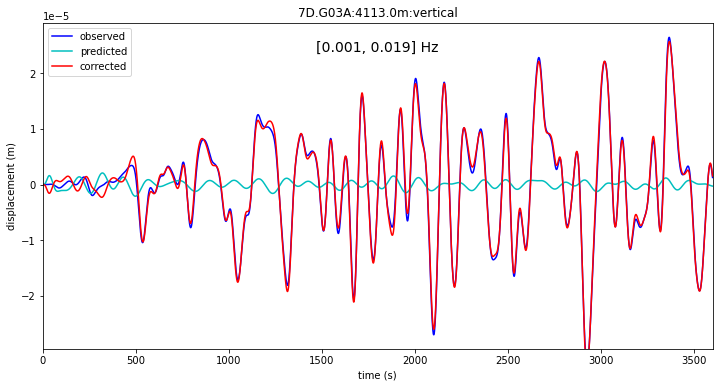

In [11]:
# get data from IRIS web service
client    = Client('IRIS')
net="7D"
sta=["G03A"]#["G03A","J35A","J44A","J65A"]
Pchanlist=["HDH","BDH"] #pressure channels
starttime = obspy.UTCDateTime("2012_01_21_0_0_0")       
endtime   = obspy.UTCDateTime("2012_01_22_0_0_0")
stlamin,stlamax,stlomin,stlomax= 37.0,52.0,-133.0,-116.0
rmresp=True #remove instrument response
rmrespoutput="DISP"
# parameters for butterworth filter
samp_freq=20
pfreqmin=0.001
pfreqmax=samp_freq/2

# prefilter information used when removing instrument responses
f1 = 0.9*pfreqmin;f2=pfreqmin
if 1.1*pfreqmax > 0.45*samp_freq:
    f3 = 0.4*samp_freq
    f4 = 0.45*samp_freq
else:
    f3 = pfreqmax
    f4= 1.1*pfreqmax
pre_filt  = [f1,f2,f3,f4]

# get relationship between water depth and maximum compliance frequency.
d=np.arange(1,5051,50) #water depth
f=maxcompfreq(d,iplot=True)

for ista in sta:
    clear_output(wait=True)
    trall=[] 
    stinv=[]
    trlabels=[]
    """
    array to save all four set of traces: 0-pressure, 1-vertical, 2-prediction of vertical from pressure,
    3-corrected vertical
    """
    
    #download pressure data first
    pchanfound=0
    for chan in Pchanlist:
        try:
            sta_invP = client.get_stations(network=net,station=ista,channel=chan,location='*', \
                            starttime=starttime,endtime=endtime,minlatitude=stlamin,maxlatitude=stlamax, \
                            minlongitude=stlomin, maxlongitude=stlomax,level='response')
            print()
            pchan=chan
            pchanfound=1
            sta,net,lon,lat,elv,location=sta_info_from_inv(sta_invP)
            print([sta,net,lon,lat,elv,location])
            
            break
        except Exception as e:
            pchanfound == 0
            
    if pchanfound == 0 and chan == Pchanlist[-1]:
        print("Pressure channels not found for "+net+"."+ista)
        continue

    stinv.append(sta_invP)
    trlabels.append(net+"."+ista+"."+pchan+":"+str(np.abs(elv))+"m:pressure")
    tr=client.get_waveforms(network=net,station=ista,\
                    channel=pchan,location="*",starttime=starttime,endtime=endtime)
    trall.append(tr[0])
    print("pressure channel "+pchan)

    #download vertical data now
    zchan=pchan[0]+"HZ"

    sta_invZ = client.get_stations(network=net,station=ista,channel=zchan,location='*', \
                    starttime=starttime,endtime=endtime,minlatitude=lamin,maxlatitude=lamax, \
                    minlongitude=lomin, maxlongitude=lomax,level='response')

    stinv.append(sta_invZ)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:vertical")
    tr=client.get_waveforms(network=net,station=ista,\
                    channel=zchan,location="*",starttime=starttime,endtime=endtime)
    trall.append(tr[0])
    print("vertical channel "+zchan)

    sps=int(trall[0].stats.sampling_rate) #assume pressure and vertical channels have the same sampling rat
    # make downsampling if needed
    if sps > samp_freq:
        # downsampling here
        print("resampling from "+str(sps)+" to "+str(samp_freq))
        for it in range(len(trall)):
            trall[it].interpolate(samp_freq,method='weighted_average_slopes')
            delta = trall[it].stats.delta

            # when starttimes are between sampling points
            fric = trall[it].stats.starttime.microsecond%(delta*1E6)
            if fric>1E-4:
                trall[it].data = segment_interpolate(np.float32(trall[it].data),float(fric/(delta*1E6)))
                #--reset the time to remove the discrepancy---
                trall[it].stats.starttime-=(fric*1E-6)

    #remove response from the two downloaded channels
    if rmresp:
        for it in range(len(trall)):
            if it == 0:continue #skip pressure channel
            if not stinv[it][0][0][0].response:
                raise ValueError('no response found in the inventory! abort!')
            else:
                try:
                    print('removing response for %s using inv'%trall[it])
                    trall[it].attach_response(stinv[it])
                    trall[it].remove_response(output=rmrespoutput,pre_filt=pre_filt,water_level=60)
                except Exception as e:
                    print(e)
                    trall[it] = []
           
    #start compliance correction
    #get the transfer function
    freqmin=pfreqmin
    freqmax=np.around(maxcompfreq(np.abs(elv)),decimals=3)
#     freqmin=0.01
#     freqmax=0.025
    delta=1.0/samp_freq
    print("getting transfer function ...")
#     trall[0].data=1000*trall[0].data #change from kpa to pa
    ff,coh,adm,phs,adm_err,phs_err = gettransfer(trall[0].data,trall[1].data,\
                                                 delta,iplot=True,winlen=2000,\
                                                figname=net+"."+ista+"."+pchan+"-"+zchan+"_debug_transfer.png")
    # do correction now.
    print("doing correction ...")
    trZ_pred,trZ_left = docorrection(trall[0],trall[1],adm,adm_err,phs,phs_err,\
                                     freqmin,freqmax,ff,iplot=1)

    trall.append(trZ_pred)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:prediction")
    trall.append(trZ_left)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:compliance corrected")
    
    #plotting
    print("plotting ...")
    tmin=np.max([trall[0].times()[0],trall[1].times()[0]])
    tmax=np.min([trall[0].times()[-1],trall[1].times()[-1]])
#     tmin=40500
#     tmax=42500
    tlen=tmax-tmin
    if tlen>3600:tlen=3600 #only plot 1 hour now
        
    plot_trace(trall,size=(12,13),title=trlabels,freqmin=freqmin,freqmax=freqmax,\
               xlimit=(tmin,tmin+tlen),subplotpar=(4,1),\
               ylabels=["pressure (kpa)","displacement (m)","displacement (m)","displacement (m)"],\
               outfile=net+"."+ista+"_correction.png",spacing=1,colors=['k','b','c','r'])
    plot_trace((trall[1],trall[2],trall[3]),size=(12,6),datalabels=["observed","predicted","corrected"],\
               title=net+"."+ista+":"+str(np.abs(elv))+"m:vertical",freqmin=freqmin,freqmax=freqmax,xlimit=(tmin,tmin+tlen),mode="overlap",\
               ylabels=["displacement (m)"],outfile=net+"."+ista+"_comparison.png",colors=['b','c','r'])

